In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
from matplotlib import rc

from Flow import *
from Model import Model
from NN import NN
from estimator import MonteCarlo, ImportanceSampling, AdaptiveImportanceSampling, WeightedMonteCarlo

In [2]:
def g(x):    
    return x**2

In [3]:
sigma_noise = 0.1
N_train = 32

noise = tf.random.normal((N_train, 1), 0, sigma_noise)

x1 = np.linspace(-1.0, -0.2, N_train//2)
x2 = np.linspace(0.2, 1.0, N_train//2)
X_train = np.stack((x1, x2)).reshape(-1, 1)
Y_train = g(X_train) + noise

x_pred = np.array([[0.0]])

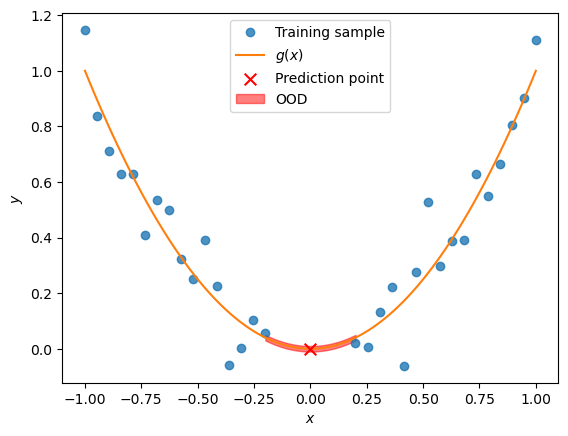

In [4]:
fig, ax = plt.subplots()

ax.plot(X_train, Y_train, 'o', label='Training sample', alpha=0.8)
ax.plot(np.linspace(-1, 1, 100), g(np.linspace(-1, 1, 100)), label=r'$g(x)$')
ax.scatter(x_pred, g(x_pred), label='Prediction point', color='red', s=70, zorder=10, marker='x')
ax.fill_between(np.linspace(-0.2, 0.2, 100), g(np.linspace(-0.2, 0.2, 100)) - 0.01, g(np.linspace(-0.2, 0.2, 100)) + 0.01, color='red', alpha=0.5, label='OOD')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()


In [5]:
prior = tfp.distributions.Uniform(-10, 10)
likelihood_std = 1e-1

gw = NN(input = 1, output = 1, hidden = 1, hidden_units=2, activation = tf.sin)
model = Model(X_train = X_train, Y_train = Y_train, gw = gw, prior = prior, likelihood_std = likelihood_std)

d = gw.count_params()
print("d = ", d)

d =  13


In [12]:
M = 100
lr = 1e-2
epochs = 1000

q0 = tfp.distributions.Uniform(-2, 2)
initializer = tf.initializers.GlorotNormal()
optimizer = tf.keras.optimizers.SGD


# flow_gf = OptimizerFlow(
#                         M = M, 
#                         epochs = epochs, 
#                         lr = lr, 
#                         model = model,
#                         burn_in = 10000, 
#                         optimizer = optimizer, 
#                         initializer = initializer
#                     )
# w_gf = flow_gf.flow()
flow_gf = GradientFlow(
                M = M,
                epochs = epochs, 
                lr = lr, 
                model = model, 
                q0 = q0, 
                burn_in = 0,
                )


# flow_gf = MixFlow(
#                 M = M, 
#                 epochs = epochs,
#                 lr = lr,
#                 model = model,
#                 q0 = q0,
#                 burn_in = 0,
#                 k = 1e-6,
# )

w_gf, logq = flow_gf.flow_and_distribution()
w_gf = flow_gf.flow()


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step


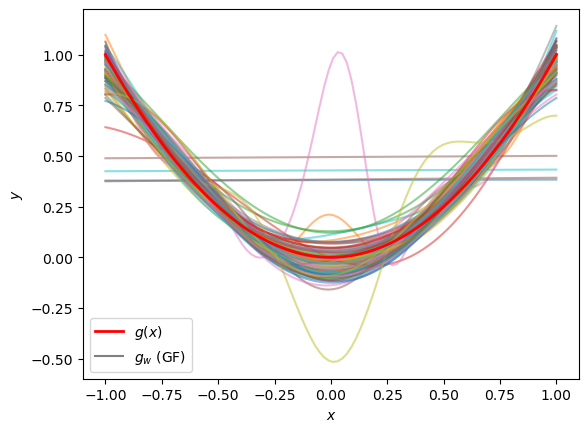

In [13]:
x_plot = np.linspace(-1, 1, 100)
y_plot_gf = model.gw(x_plot.reshape(-1, 1), w_gf[-1]).numpy().squeeze().T

fig, ax = plt.subplots()
ax.plot(x_plot, y_plot_gf, alpha = 0.5)
ax.plot(np.linspace(-1, 1, 100), g(np.linspace(-1, 1, 100)), label=r'$g(x)$', color='red', linewidth=2)
ax.plot([], [], label = r"$g_w$ (GF)", color='k', alpha=0.5)


plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()    
plt.show()

In [14]:
est_mc = MonteCarlo(model = model, samples_weight = w_gf)
mean_mc, var_mc = est_mc.estimate(x_pred)

est_is = ImportanceSampling(model = model, samples_weight = w_gf, logq = logq)
mean_is, var_is = est_is.estimate(x_pred)

est_ais = AdaptiveImportanceSampling(model = model, samples_weight = w_gf, logq = logq)
mean_ais, var_ais = est_ais.estimate(x_pred)

In [15]:
print(np.isnan(w_gf).sum())

0


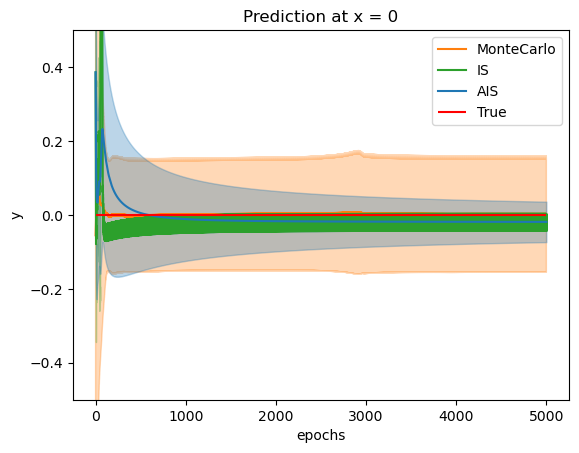

In [16]:
time = np.arange(0, epochs)

fig, ax = plt.subplots()

ax.plot(time, mean_mc, color = "tab:orange", label = "MonteCarlo")
ax.fill_between(time, mean_mc - np.sqrt(var_mc), mean_mc + np.sqrt(var_mc), alpha = 0.3, color = "tab:orange")

ax.plot(time, mean_is, color = "tab:green", label = "IS")
ax.fill_between(time, mean_is - np.sqrt(var_is), mean_is + np.sqrt(var_is), alpha = 0.3, color = "tab:green")

ax.plot(time, mean_ais, color = "tab:blue", label = "AIS")
ax.fill_between(time, mean_ais - np.sqrt(var_ais), mean_ais + np.sqrt(var_ais), alpha = 0.3, color = "tab:blue")

ax.hlines(0.0, 0, epochs, label = "True", color = "red")

ax.set_ylim(-0.5, 0.5)
ax.set_xlabel("epochs")
ax.set_ylabel("y")
ax.set_title("Prediction at x = 0")

plt.legend()
plt.show()

